(irk-exercises-section)=

# Implicit Runge-Kutta methods exercises


`````{exercise}
:label: ch3-ex-radauIA-order

Determine the order of the DIRK method shown below.

$$ \begin{array}{c|cc}
    1/4 & 1/4 \\
    3/4 & 1/2 & 1/4 \\ \hline
    & 1/2 & 1/2
\end{array} $$

```{dropdown} Solution
This DIRK method is a second-order method.
```
`````

`````{exercise}
:label: ch3-ex-radauIIA-derivation

Derive a third-order Radau IIA method. Present your method in a Butcher tableau.

```{dropdown} Solution
$$ \begin{array}{c|cc}
    \frac{1}{3} & \frac{5}{12} & -\frac{1}{12} \\
    1 & \frac{3}{4} & \frac{1}{4} \\ \hline
    & \frac{3}{4} & \frac{1}{4}
\end{array} $$
```
`````

`````{exercise}
:label: ch3-ex-robertson

The {cite:t}`robertson:1966` model describes the following chemical reaction between three chemicals

$$ \begin{align*}
    A &\xrightarrow{k_1} B, \\
    B &\xrightarrow{k_2} C, \\
    B + B &\xrightarrow{k_3} C,
\end{align*} $$

where $A$, $B$ and $C$ are the concentration of the three chemicals and $k_1 = 0.04$, $k_2 = 3 \times 10^{7}$ and $k_3 = 10^{4}$ are parameters determining the reaction rates. Writing these as a system of ODEs gives

$$ \begin{align*}
    \frac{\mathrm{d}A}{\mathrm{d}t} &= -k_1A, \\
    \frac{\mathrm{d}B}{\mathrm{d}t} &= k_1A - k_2B - k_3B^2, \\
    \frac{\mathrm{d}C}{\mathrm{d}t} &= k_2B + k_3B^2.
\end{align*} $$

(a) &emsp; Write a Python or MATLAB program to solve the Robertson model over $t \in [0, 100]$, with initial values $A(0) = 1$ and $B(0) = C(0) = 0$ using the Radau IIA model from {ref}`ch3-ex-radauIIA-derivation` with a step length of $h = 1$. Produce a plot of the concentrations of the three chemicals over $t$ on the same axes, with $B$ multiplied by a scaling factor of $10^5$ so that it is visible on the plot.

````{dropdown} Solution
```{glue:figure} ex3.3_plot
```
````

(b) &emsp; Solve the same IVP using the [Fehlberg 5(4) ERK method](ssc-code-section). Determine the smallest step length used throughout the solution.

```{dropdown} Solution
The smallest step length used by the Fehlberg 5(4) method was $h = 1.48 \times 10^{-4}$
```


(c) &emsp; Comment on the applicability of the two methods used here to solve this IVP. Why do your think one method took longer than the other?

```{dropdown} Solution
The Fehlberg 5(4) ERK method took much longer than the Radau IIA IRK method to compute the solution. This was because the chemical reaction is violent as indicated by the plot of the solution which shows the concentration of $B$ increasing rapidly shortly after the start of the reaction. This means the Fehlberg 5(4) ERK method is having to use a very small step length to ensure accuracy. The Robertson model is an example of a stiff problem which the Radau class of IRK methods are more suited to solving than an ERK method (stiffness is covered in the [next chapter](stiffness-section)).
```
`````


1


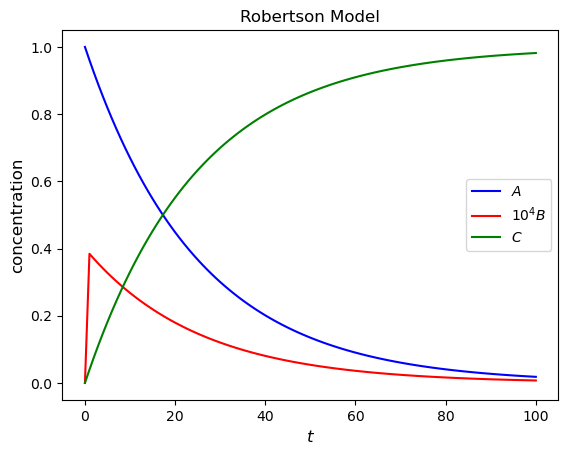

In [54]:
import numpy as np
import matplotlib.pyplot as plt

def jac(f, t, y):
    J = np.zeros((len(y), len(y)))
    epsilon = 1e-6
    for i in range(len(y)):
        y_plus_epsilon = y.astype(float)
        y_minus_epsilon = y.astype(float)
        y_plus_epsilon[i] += epsilon
        y_minus_epsilon[i] -= epsilon
        J[:,i] = (f(t, y_plus_epsilon) - f(t,y_minus_epsilon)) / (2 * epsilon)

    return J


def radauIIA(f, tpsan, y0, h):
    
    N = len(y0)
    nsteps = int((tspan[1] - tspan[0]) / h)
    t = np.zeros(nsteps + 1)
    y = np.zeros((N, nsteps + 1))
    t[0] = tspan[0]
    y[:,0] = y0
    
    A = np.array([[1/3, -1/12],
                  [3/4, 1/4]])
    b = np.array([3/4, 1/4])
    c = np.array([1/3, 1])
    s = 2
    maxk = 0

    for n in range(nsteps):
        z = np.zeros(N * s)
        F = np.zeros(N * s)
        J = jac(f, t[n], y[:,n])
        for k in range(10):
            F[:N] = f(t[n] + c[0] * h, y[:,n] + z[:N])
            F[N:] = f(t[n] + c[1] * h, y[:,n] + z[N:])
            g = z - h * np.dot(np.kron(A, np.eye(N)), F)
            delta_z = np.linalg.solve(np.eye(N * s) - h * np.kron(A, J), -g)
            z += delta_z
            if np.linalg.norm(delta_z) < 1e-6:
                break

        maxk = max(k, maxk)
        
        y[:,n+1] = y[:,n] + h * np.dot(np.kron(b.T, np.eye(N)), F)
        t[n+1] = t[n] + h

    print(maxk)

    return t, y.T


def rkf45(f, tspan, y0, atol=1e-6, rtol=1e-3):
    
    N = len(y0)
    t = np.zeros(1000000)
    y = np.zeros((N, 1000000)) 
    t[0] = tspan[0]
    y[:,0] = y0
    
    h = 0.8 * rtol ** (1 / 5)
    n = 0
    minh = 9999
    while t[n] < tspan[-1]:

        k1 = f(t[n], y[:,n])
        k2 = f(t[n] + 1/4 * h, y[:,n] + 1/4 * h * k1)
        k3 = f(t[n] + 3/8 * h, y[:,n] + h * (3/23 * k1 + 9/32 * k2))
        k4 = f(t[n] + 12/13 * h, y[:,n] + h * (1932/2197 * k1 - 7200/2197 * k2 + 7296/2197 * k3))
        k5 = f(t[n] + h, y[:,n] + h * (439/216 * k1 - 8 * k2 + 3680/513 * k3 - 845/4104 * k4))
        k6 = f(t[n] + 1/2 * h, y[:,n] + h * (-8/27 * k1 + 2 * k2 - 3544/2565 * k3 + 1859/4104 * k4 - 11/40 * k5))

        y5 = y[:,n] + h * (16/135 * k1 + 6656/12825 * k3 + 28561/56430 * k4 - 9/50 * k5 + 2/55 * k6)
        y4 = y[:,n] + h * (25/216 * k1 + 1408/2565 * k3 + 2197//4104 * k4 - 1/5 * k5)

        delta = np.linalg.norm(y5 - y4)
        tol = atol + rtol * np.linalg.norm(y5)
        if delta < tol:
            y[:,n+1] = y5
            t[n+1] = t[n] + h
            n += 1
        
        r = max(0.1, 0.8 * (tol / delta) ** (1/5))
        minh = min(r * h, minh)
        h = min(r * h, tspan[-1] - t[n])

    print(f"minimum step length = {minh:1.2e}")

    return t[:n+1], y[:,:n+1].T


# Define Robertson's equations
def robertson(t, y):
    dA = -k1 * y[0]
    dB = k1 * y[0] - k2 * y[1] - k3 * y[2] ** 2
    dC = k2 * y[1] + k3 * y[1] ** 2
    return np.array([dA, dB, dC])


# Define IVP
tspan = [0, 100]
y0 = [1, 0, 0]
h = 1
k1, k2, k3 = 0.04, 1e4, 3e-7

# Solve IVP
# t_rkf45, y_rkf45 = rkf45(robertson, tspan, y0)
t, y = radauIIA(robertson, tspan, y0, h)

# Plot solution
fig, ax = plt.subplots()
plt.plot(t, y[:,0], "b", label="$A$")
plt.plot(t, y[:,1] * 1e5, "r", label="$10^4 B$")
plt.plot(t, y[:,2], "g", label="$C$")
plt.xlabel("$t$", fontsize=12)
plt.ylabel("concentration", fontsize=12)
plt.title("Robertson Model")
plt.legend()
plt.show()


from myst_nb import glue
glue("ex3.3_plot", fig, display=False)